<a href="https://colab.research.google.com/github/aamir-ansari-44/Study/blob/main/Adv.%20Supervised%20Learning/lec_2_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## **Problem Statement: Building Stock Portfolios**

**Goal :** Creating pools of stocks that move together(similar characteristics) on one or more fundamental financial metric.

In previous lecture we studied about K-Means clustering and how we can use it for customer segmentation.

In today's lecture we'll study some other clustering techniques, why they are required, what are the limitations of K-Means, and we'll use all this knowledge to build stock portfolios.

Let's first have a look at the dataset that we'll be using.

#### **Dataset - Top 50 NSE stocks**

- Contains company's stock symbol
- Name, Industry and other details

Lets import the dependencies

In [ ]:
  import pandas as pd
  import numpy as np
  from matplotlib import pyplot as plt
  plt.rcParams["figure.figsize"] = (18,10)
  import seaborn as sns

Reading the data

In [ ]:
!wget "https://drive.google.com/uc?export=download&id=1giO5bbp3l0INVvTQIGJ7s_Ai5_TWNuIb" -O ind_nifty50list.csv

--2023-10-04 05:57:46--  https://drive.google.com/uc?export=download&id=1giO5bbp3l0INVvTQIGJ7s_Ai5_TWNuIb
Resolving drive.google.com (drive.google.com)... 173.194.196.113, 173.194.196.139, 173.194.196.100, ...
Connecting to drive.google.com (drive.google.com)|173.194.196.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/job7iau1j3qf6d4su1u12qf126rv777a/1696399050000/10306167880925931714/*/1giO5bbp3l0INVvTQIGJ7s_Ai5_TWNuIb?e=download&uuid=89c08420-1b59-4d25-8182-1a76806fb10f [following]
--2023-10-04 05:57:47--  https://doc-08-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/job7iau1j3qf6d4su1u12qf126rv777a/1696399050000/10306167880925931714/*/1giO5bbp3l0INVvTQIGJ7s_Ai5_TWNuIb?e=download&uuid=89c08420-1b59-4d25-8182-1a76806fb10f
Resolving doc-08-64-docs.googleusercontent.com (doc-08-64-docs.googleusercontent.com)... 64.233.181.132, 2

**Installing yfinance**


- **yfinance** is a library that helps us download market data from yahoo finance's api.

- So lets install these libraries into our environment using pip.

- You can read more about it <a href="https://pypi.org/project/yfinance/"> here: https://pypi.org/project/yfinance/ </a>


In [ ]:
!pip install yfinance

In [ ]:
# Since yfinance is an old library, it also has some glitches, so we install this library as a fix
!pip install fix-yahoo-finance

  Preparing metadata (setup.py) ... done
  Created wheel for fix-yahoo-finance: filename=fix_yahoo_finance-0.1.37-py3-none-any.whl size=7073 sha256=7912e111a1dcb9761c0646345164890d2849e9b021a5106aad0baf474eda2ce1
  Stored in directory: /root/.cache/pip/wheels/1e/5e/ca/d9dbe97f5c895289286a5f99311e9e9633c9898f35d42802ca
Successfully built fix-yahoo-finance


#### EDA
#### **Importing Data**

- Purpose of this dataset: Getting list of Company names which are stored in the 'Symbol' column of the data

In [ ]:
stocks_df = pd.read_csv("./ind_nifty50list.csv")
list_of_symbols = list(stocks_df['Symbol'])
stocks_df.head()

,Company Name,Industry,Symbol,Series,ISIN Code
0,Adani Ports and Special Economic Zone Ltd.,SERVICES,ADANIPORTS,EQ,INE742F01042
1,Asian Paints Ltd.,CONSUMER GOODS,ASIANPAINT,EQ,INE021A01026
2,Axis Bank Ltd.,FINANCIAL SERVICES,AXISBANK,EQ,INE238A01034
3,Bajaj Auto Ltd.,AUTOMOBILE,BAJAJ-AUTO,EQ,INE917I01010
4,Bajaj Finance Ltd.,FINANCIAL SERVICES,BAJFINANCE,EQ,INE296A01024


**Now, we'll take symbols from original dataset**
- We'll add `.NS` at the end of every symbol to fetch data from Yahoo Finance based on company's symbol.

In [ ]:
yf_symbols = list(map(lambda x: x + '.NS', list_of_symbols))
yf_symbols

['ADANIPORTS.NS',
 'ASIANPAINT.NS',
 'AXISBANK.NS',
 'BAJAJ-AUTO.NS',
 'BAJFINANCE.NS',
 'BAJAJFINSV.NS',
 'BPCL.NS',
 'BHARTIARTL.NS',
 'BRITANNIA.NS',
 'CIPLA.NS',
 'COALINDIA.NS',
 'DIVISLAB.NS',
 'DRREDDY.NS',
 'EICHERMOT.NS',
 'GRASIM.NS',
 'HCLTECH.NS',
 'HDFCBANK.NS',
 'HDFCLIFE.NS',
 'HEROMOTOCO.NS',
 'HINDALCO.NS',
 'HINDUNILVR.NS',
 'HDFC.NS',
 'ICICIBANK.NS',
 'ITC.NS',
 'IOC.NS',
 'INDUSINDBK.NS',
 'INFY.NS',
 'JSWSTEEL.NS',
 'KOTAKBANK.NS',
 'LT.NS',
 'M&M.NS',
 'MARUTI.NS',
 'NTPC.NS',
 'NESTLEIND.NS',
 'ONGC.NS',
 'POWERGRID.NS',
 'RELIANCE.NS',
 'SBILIFE.NS',
 'SHREECEM.NS',
 'SBIN.NS',
 'SUNPHARMA.NS',
 'TCS.NS',
 'TATACONSUM.NS',
 'TATAMOTORS.NS',
 'TATASTEEL.NS',
 'TECHM.NS',
 'TITAN.NS',
 'UPL.NS',
 'ULTRACEMCO.NS',
 'WIPRO.NS']

**Now, we'll define some variables and fetch the corresponding data from Yahoo Finance for the companies in our list**

> **Instructor's Note**:
- Below given given takes a lot of time, Run in Advance.

In [ ]:
import yfinance as yf


stock_financials = {
    'marketCap': [],
    'regularMarketVolume': [],
    'earningsQuarterlyGrowth': [],
    'bookValue': [],
    'totalRevenue': [],
    'returnOnAssets': [],
    'profitMargins': [],
    'earningsGrowth': []
    }

for ticker in yf_symbols:
    stock_info = yf.Ticker(ticker).info
    stock_financials['marketCap'].append(stock_info.get('marketCap', None))
    stock_financials['regularMarketVolume'].append(stock_info.get('regularMarketVolume', None))
    stock_financials['earningsQuarterlyGrowth'].append(stock_info.get('earningsQuarterlyGrowth', None))
    stock_financials['bookValue'].append(stock_info.get('bookValue', None))
    stock_financials['totalRevenue'].append(stock_info.get('totalRevenue', None))
    stock_financials['returnOnAssets'].append(stock_info.get('returnOnAssets', None))
    stock_financials['profitMargins'].append(stock_info.get('profitMargins', None))
    stock_financials['earningsGrowth'].append(stock_info.get('earningsGrowth', None))

**Q. What have we collected?**
We 've collected attributes such as '**marketCap**', '**regularMarketVolume**' and others for companies that we collected in variable '**yf_symbols**'

In [ ]:
df = pd.DataFrame(stock_financials)
df.head()

,marketCap,regularMarketVolume,earningsQuarterlyGrowth,bookValue,totalRevenue,returnOnAssets,profitMargins,earningsGrowth
0,1815057661952,1721353,0.972,210.251,220413706240,NaN,0.28431,0.927
1,3049975971840,245690,0.525,166.725,350034591744,NaN,0.13255,0.525
2,3111807090688,13737511,0.391,442.406,565070594048,0.01008,0.22173,0.384
3,1414548422656,120591,0.413,1037.667,396634685440,NaN,0.16491,0.445
4,4784184623104,622959,0.324,899.572,272220405760,NaN,0.45361,0.323


In [ ]:
df.shape

(50, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   marketCap                50 non-null     int64  
 1   regularMarketVolume      50 non-null     int64  
 2   earningsQuarterlyGrowth  47 non-null     float64
 3   bookValue                49 non-null     float64
 4   totalRevenue             50 non-null     int64  
 5   returnOnAssets           13 non-null     float64
 6   profitMargins            50 non-null     float64
 7   earningsGrowth           47 non-null     float64
dtypes: float64(5), int64(3)
memory usage: 3.2 KB


**Downloading stock price data**
- Purpose of this data: Getting returns of the stocks

In [ ]:
import yfinance as yf

stock_prices = yf.download(yf_symbols, start='2020-01-01')['Adj Close']
stock_prices.columns = list_of_symbols

[*********************100%%**********************]  50 of 50 completed


 - 'Adj Close' refers to Adjusted close which is used in stock market. It is the closing price after adjustments for all applicable splits and dividend distributions

In [ ]:
stock_prices.shape

(934, 50)

In [ ]:
stock_prices.tail()

,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,BRITANNIA,CIPLA,...,SUNPHARMA,TCS,TATACONSUM,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,WIPRO
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-27,830.700012,3301.800049,1025.199951,5032.950195,1565.750000,7837.549805,920.250000,349.000000,4627.350098,1180.500000,...,1139.949951,888.849976,620.150024,128.149994,3589.300049,1288.650024,3214.550049,8262.700195,615.099976,415.649994
2023-09-28,823.099976,3170.350098,1030.900024,5006.600098,1539.699951,7739.000000,925.650024,343.950012,4524.549805,1164.050049,...,1132.300049,876.500000,614.099976,126.800003,3536.750000,1229.500000,3157.250000,8154.350098,605.000000,405.350006
2023-09-29,825.150024,3161.050049,1036.699951,5063.700195,1540.250000,7810.750000,926.400024,346.600006,4537.149902,1186.150024,...,1158.650024,876.900024,630.200012,128.899994,3528.600098,1222.800049,3148.800049,8254.849609,616.250000,406.049988
2023-10-03,831.400024,3166.850098,1041.050049,5016.450195,1561.050049,7967.600098,925.299988,341.350006,4495.450195,1182.800049,...,1141.449951,871.900024,620.450012,128.000000,3513.850098,1216.199951,3196.250000,8304.900391,607.000000,405.450012
2023-10-04,840.799988,NaN,NaN,4958.600098,1535.650024,7900.000000,923.849976,343.549988,4504.299805,1167.800049,...,1120.699951,866.599976,NaN,125.800003,3490.149902,1196.150024,3164.000000,8165.600098,NaN,403.299988


In [ ]:
# splitting data by year - 2020 returns
price_2020 = stock_prices.loc["2020-01-02 00:00:00":"2020-12-31 00:00:00"]

# to see % growth of the stock: ((endDate/startDate) - 1) * 100
stock_prices.loc['returns_2020'] = (price_2020.loc['2020-08-04 00:00:00'] / price_2020.loc['2020-01-02 00:00:00'] - 1)*100

stock_prices

,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,BRITANNIA,CIPLA,...,SUNPHARMA,TCS,TATACONSUM,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,WIPRO
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,365.911530,1746.541992,746.027344,2640.764648,935.770386,4163.675293,447.652802,389.949860,2744.026611,462.176971,...,416.195679,313.626343,183.876907,19.196709,2013.780151,649.109436,1131.735474,3991.287354,557.155334,243.122696
2020-01-02 00:00:00,371.240601,1744.058472,754.247864,2616.369629,948.457275,4178.189453,449.529114,386.697968,2756.439697,459.846191,...,416.818604,313.142120,193.148010,19.898500,2004.536377,652.473755,1132.568359,4167.827148,563.974792,243.711609
2020-01-03 00:00:00,370.610809,1705.829834,740.297852,2575.334717,932.517639,4126.430176,449.430389,383.485718,2743.260010,456.398590,...,426.066376,308.154724,190.506256,19.851303,2044.484619,660.182129,1116.985352,4142.691406,559.523193,246.459869
2020-01-06 00:00:00,368.382263,1662.731079,720.668152,2546.496338,902.269714,3932.824463,444.048248,372.104095,2728.138428,453.290863,...,421.610229,302.247284,185.073181,19.422428,2044.299316,656.178955,1135.508545,4081.717529,554.029846,247.490463
2020-01-07 00:00:00,372.839294,1679.532227,723.159241,2546.748047,907.553040,3943.599854,439.554962,365.639984,2741.273438,455.087524,...,427.791321,304.958862,184.126129,19.539396,2049.315918,661.885559,1136.831787,4165.175781,563.595947,250.484100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-28 00:00:00,823.099976,3170.350098,1030.900024,5006.600098,1539.699951,7739.000000,925.650024,343.950012,4524.549805,1164.050049,...,1132.300049,876.500000,614.099976,126.800003,3536.750000,1229.500000,3157.250000,8154.350098,605.000000,405.350006
2023-09-29 00:00:00,825.150024,3161.050049,1036.699951,5063.700195,1540.250000,7810.750000,926.400024,346.600006,4537.149902,1186.150024,...,1158.650024,876.900024,630.200012,128.899994,3528.600098,1222.800049,3148.800049,8254.849609,616.250000,406.049988
2023-10-03 00:00:00,831.400024,3166.850098,1041.050049,5016.450195,1561.050049,7967.600098,925.299988,341.350006,4495.450195,1182.800049,...,1141.449951,871.900024,620.450012,128.000000,3513.850098,1216.199951,3196.250000,8304.900391,607.000000,405.450012


In [ ]:
stock_prices = stock_prices.transpose()
stock_prices.head()

Date,2020-01-01 00:00:00,2020-01-02 00:00:00,2020-01-03 00:00:00,2020-01-06 00:00:00,2020-01-07 00:00:00,2020-01-08 00:00:00,2020-01-09 00:00:00,2020-01-10 00:00:00,2020-01-13 00:00:00,2020-01-14 00:00:00,...,2023-09-21 00:00:00,2023-09-22 00:00:00,2023-09-25 00:00:00,2023-09-26 00:00:00,2023-09-27 00:00:00,2023-09-28 00:00:00,2023-09-29 00:00:00,2023-10-03 00:00:00,2023-10-04 00:00:00,returns_2020
ADANIPORTS,365.911530,371.240601,370.610809,368.382263,372.839294,373.662872,379.621735,379.863953,378.216797,377.102539,...,831.099976,827.049988,825.650024,821.349976,830.700012,823.099976,825.150024,831.400024,840.799988,-16.891375
ASIANPAINT,1746.541992,1744.058472,1705.829834,1662.731079,1679.532227,1683.817749,1726.429443,1745.909058,1757.937744,1771.816895,...,3244.199951,3274.850098,3323.250000,3292.800049,3301.800049,3170.350098,3161.050049,3166.850098,NaN,-3.813729
AXISBANK,746.027344,754.247864,740.297852,720.668152,723.159241,721.913696,740.198181,737.408203,734.767639,745.230164,...,1014.450012,1018.250000,1018.950012,1014.150024,1025.199951,1030.900024,1036.699951,1041.050049,NaN,-43.305373
BAJAJ-AUTO,2640.764648,2616.369629,2575.334717,2546.496338,2546.748047,2564.604004,2586.777344,2599.771240,2593.777344,2600.106689,...,5085.200195,5001.049805,5005.450195,5069.200195,5032.950195,5006.600098,5063.700195,5016.450195,4958.600098,-0.566446
BAJFINANCE,935.770386,948.457275,932.517639,902.269714,907.553040,912.527039,937.446777,935.151855,943.433472,953.371399,...,1526.199951,1543.699951,1577.400024,1567.699951,1565.750000,1539.699951,1540.250000,1561.050049,1535.650024,-35.138663


**Putting the data together**

In [ ]:
prices = stock_prices.iloc[:, -1]
df.index = stock_prices.index
df['return_2020'] = prices
df.head()

,marketCap,regularMarketVolume,earningsQuarterlyGrowth,bookValue,totalRevenue,returnOnAssets,profitMargins,earningsGrowth,return_2020
ADANIPORTS,1815057661952,1721353,0.972,210.251,220413706240,NaN,0.28431,0.927,-16.891375
ASIANPAINT,3049975971840,245690,0.525,166.725,350034591744,NaN,0.13255,0.525,-3.813729
AXISBANK,3111807090688,13737511,0.391,442.406,565070594048,0.01008,0.22173,0.384,-43.305373
BAJAJ-AUTO,1414548422656,120591,0.413,1037.667,396634685440,NaN,0.16491,0.445,-0.566446
BAJFINANCE,4784184623104,622959,0.324,899.572,272220405760,NaN,0.45361,0.323,-35.138663


**Checking for null values**

In [ ]:
df.isna().sum()

marketCap                   0
regularMarketVolume         0
earningsQuarterlyGrowth     3
bookValue                   1
totalRevenue                0
returnOnAssets             37
profitMargins               0
earningsGrowth              3
return_2020                 1
dtype: int64

In [ ]:
df['returnOnAssets'] = df['returnOnAssets'].replace(np.nan, 0)

In [ ]:
df.dropna(axis=0, inplace=True)
df.shape

(45, 9)

In [ ]:
df.head()

,marketCap,regularMarketVolume,earningsQuarterlyGrowth,bookValue,totalRevenue,returnOnAssets,profitMargins,earningsGrowth,return_2020
ADANIPORTS,1815057661952,1721353,0.972,210.251,220413706240,0.00000,0.28431,0.927,-16.891375
ASIANPAINT,3049975971840,245690,0.525,166.725,350034591744,0.00000,0.13255,0.525,-3.813729
AXISBANK,3111807090688,13737511,0.391,442.406,565070594048,0.01008,0.22173,0.384,-43.305373
BAJAJ-AUTO,1414548422656,120591,0.413,1037.667,396634685440,0.00000,0.16491,0.445,-0.566446
BAJFINANCE,4784184623104,622959,0.324,899.572,272220405760,0.00000,0.45361,0.323,-35.138663


**Q. Should we Scale the values?**

- The data seems to be in different scales
- Different financial metrics have different scales.
- We need to put them on the same scale.

We can use `StandardScaler` from `sklearn`

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df)
X = scaler.transform(df)

In [ ]:
scaled_df = pd.DataFrame(X, columns=df.columns, index=df.index)

In [ ]:
scaled_df

,marketCap,regularMarketVolume,earningsQuarterlyGrowth,bookValue,totalRevenue,returnOnAssets,profitMargins,earningsGrowth,return_2020
ADANIPORTS,-0.422089,-0.194786,1.402555,-0.435131,-0.576777,-0.391162,1.374430,1.317802,-0.371467
ASIANPAINT,0.000909,-0.411854,0.534241,-0.486906,-0.493051,-0.391162,-0.160617,0.540527,0.098512
AXISBANK,0.022088,1.572774,0.273941,-0.158974,-0.354153,-0.222180,0.741436,0.267900,-1.320722
BAJAJ-AUTO,-0.559276,-0.430256,0.316677,0.549110,-0.462951,-0.391162,0.166703,0.385845,0.215212
BAJFINANCE,0.594930,-0.356359,0.143791,0.384841,-0.543313,-0.391162,3.086893,0.149955,-1.027230
BAJAJFINSV,-0.204371,-0.339176,0.454597,-0.338617,-0.150463,-0.391162,-0.691349,0.434183,-0.613359
BHARTIARTL,0.804705,-0.300284,-0.479763,-0.524191,0.209571,-0.391162,-0.913777,-0.509376,-0.181857
BRITANNIA,-0.672057,-0.437899,0.205952,-0.510691,-0.612239,-0.391162,-0.009094,0.213762,1.184791
CIPLA,-0.720828,-0.381523,0.390493,-0.340260,-0.567286,-0.391162,-0.162842,0.397446,2.073843
COALINDIA,-0.432160,-0.040898,-0.675960,-0.574737,0.177574,-0.391162,0.487955,-0.664057,-0.968670


In [ ]:
scaled_df.to_pickle('scaled_df.pkl')

What we can do now is we can apply K-Means to solve this use-case as well. But, let's first see what are some drawbacks and limitations of K-Means.

---

## **K-Means Intitialization**

- K-Means is **Initialization dependent**. This is one of the major drawbacks of K-Means.

- This means, that the same data, with different initialization, will get different results (different clusters)

<img src='https://drive.google.com/uc?id=1KGZH4R5spf-nbx975TVct8POa7i8m3Wm'>


> **Notes:**

Images shown below can be found here: https://cs.wmich.edu/alfuqaha/summer14/cs6530/lectures/ClusteringAnalysis.pdf

Alternative link: https://drive.google.com/file/d/1ok4aGA1AZna3XyodOrLO8DYbZImpI7l9/view?usp=sharing

The docoument belongs to folks at University of Michigan. You can mention this in the lecture.

#### This is how K-Means would give different results with different initializations

<img src="https://drive.google.com/uc?export=view&id=1_8XrEVwmo47dHUkJfNKXXtF1CQE5eMG2">

* In Optimal Clustering results, results are sensible
* In Sub-Optimal Clustering, which probably doesn't make sense and won't be an optimal one


> **Notes**

Use this <a href ="https://www.naftaliharris.com/blog/visualizing-k-means-clustering/">visualization tool </a> for intuitive explanation of K-Means initialization problem. While choosing. You can play around with different options, and can use whatever suits best

Using Python, let's see how random initialization gives different results over same data.

#####**K-Means Random-State 1**

In [ ]:
from sklearn.cluster import KMeans

km1 = KMeans(n_clusters = 3, init='random')
y_km = km1.fit_predict(scaled_df)
viz_df = scaled_df
viz_df['y_km'] = y_km

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


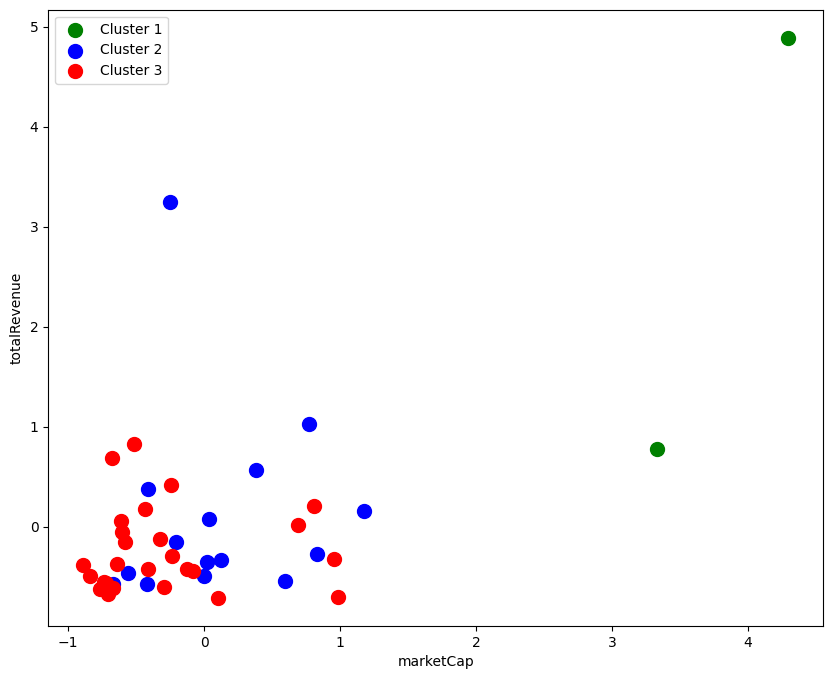

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(viz_df[viz_df['y_km'] == 0]['marketCap'], viz_df[viz_df['y_km'] == 0]['totalRevenue'], s=100, c='Green', label='Cluster 1')
plt.scatter(viz_df[viz_df['y_km'] == 1]['marketCap'], viz_df[viz_df['y_km'] == 1]['totalRevenue'], s=100, c='Blue', label='Cluster 2')
plt.scatter(viz_df[viz_df['y_km'] == 2]['marketCap'], viz_df[viz_df['y_km'] == 2]['totalRevenue'], s=100, c='Red', label='Cluster 3')
plt.xlabel('marketCap')
plt.ylabel('totalRevenue')
plt.legend()
plt.show()

#####**K-Means Random-State 2**

In [ ]:
km2 = KMeans(n_clusters = 3, init='random')
y_km2 = km2.fit_predict(scaled_df)
viz_df['y_km2'] = y_km2

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


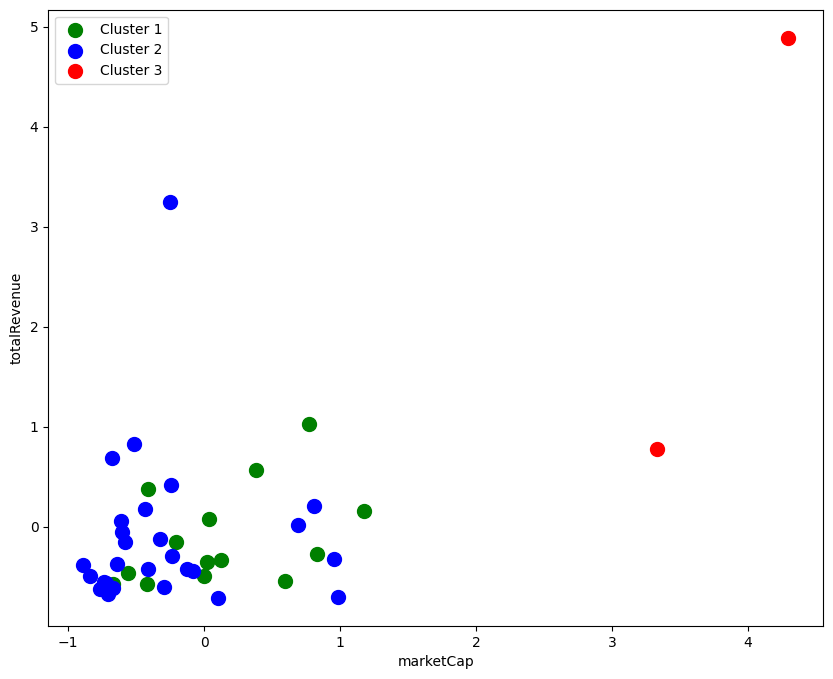

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(viz_df[viz_df['y_km2'] == 0]['marketCap'], viz_df[viz_df['y_km2'] == 0]['totalRevenue'], s=100, c='Green', label='Cluster 1')
plt.scatter(viz_df[viz_df['y_km2'] == 1]['marketCap'], viz_df[viz_df['y_km2'] == 1]['totalRevenue'], s=100, c='Blue', label='Cluster 2')
plt.scatter(viz_df[viz_df['y_km2'] == 2]['marketCap'], viz_df[viz_df['y_km2'] == 2]['totalRevenue'], s=100, c='Red', label='Cluster 3')
plt.xlabel('marketCap')
plt.ylabel('totalRevenue')
plt.legend()
plt.show()

#####**K-Means Random-State 3**

In [ ]:
km3 = KMeans(n_clusters = 3, init='random')
y_km3 = km3.fit_predict(scaled_df)
viz_df['y_km3'] = y_km3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


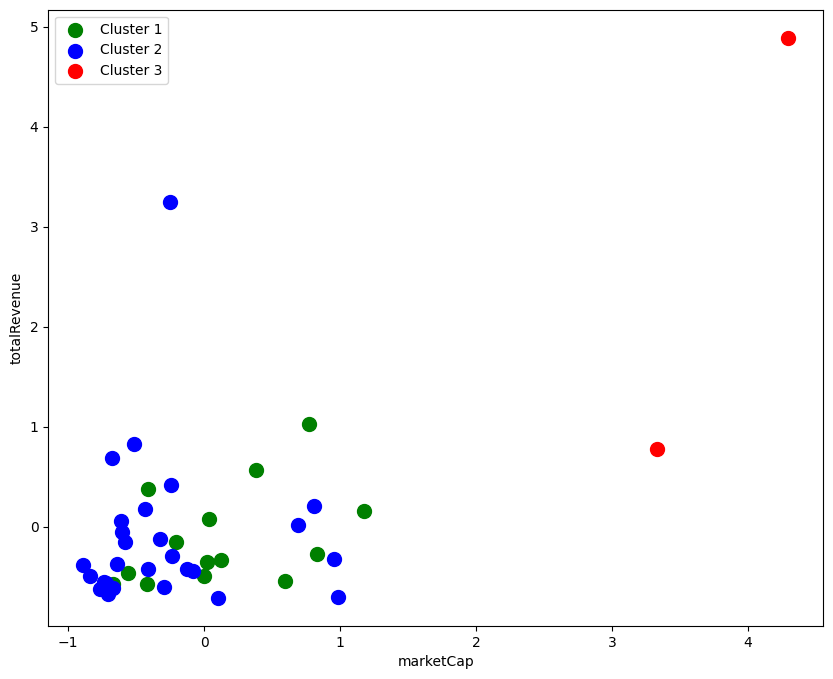

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(viz_df[viz_df['y_km3'] == 0]['marketCap'], viz_df[viz_df['y_km3'] == 0]['totalRevenue'], s=100, c='Green', label='Cluster 1')
plt.scatter(viz_df[viz_df['y_km3'] == 1]['marketCap'], viz_df[viz_df['y_km3'] == 1]['totalRevenue'], s=100, c='Blue', label='Cluster 2')
plt.scatter(viz_df[viz_df['y_km3'] == 2]['marketCap'], viz_df[viz_df['y_km3'] == 2]['totalRevenue'], s=100, c='Red', label='Cluster 3')
plt.xlabel('marketCap')
plt.ylabel('totalRevenue')
plt.legend()
plt.show()

#### **Q. Why it is important to choose good Initial Centroids?**

1. Good Initialization

 * Suppose you've initialized three centroids C1, C2, and C3
 * We know that centroids get updated after each iteration
 * When they don't, we conclude that K-Means has converged
 * The diagram shows three such clusters: S1, S2 and S3
 * This seems like a good initialization

<img src="https://drive.google.com/uc?export=view&id=1bP-rLsBKfqHmWCiqynzXvjfVwmX0jBii">


2. Bad Initialization:
  * Suppose we've initialized three clusters C1, C2, and C3 in different way
  * After iteration 4, the centroids didn't get updated
  * We conclude that K-Means has converged after 5 iterations
  * We've still clustered datapoints into 3 groups, but they are not optimal


<img src="https://drive.google.com/uc?export=view&id=1j7WfPAxskKBQ08fMY68RdX03uB52wDOR">

#### **Q. So, how to deal with initialization problem in K-Means?**

- Remember dunn index from previous lecture;
  $D = \Large\frac{min_{i,j} distance(i,j)}{max_k distance^{'}(k)}$; where,

    - distance(i,j) → distance between the farthest points of the clusters $C_i$ and $C_j$ → **Inter-Cluster distance**

- We also learnt Lloyd's Algorithm in the previous lecture in which we randomly intialize the centroids and based on the distances of centroids, we keep updating them until convergence.

- One way to deal with initialization problem would be to try different initializations for Lloyd's Algorithm and pick the best one out of it based on Dunn Index or any other evaluation metric

- But, this is a brute force approach

- This brings us to another algorithm: **K-Means++**


<img src="https://drive.google.com/uc?export=view&id=1XhLKZp7aPuWJ45wEL2SaCQEYaYYkuto9">
<img src="https://drive.google.com/uc?export=view&id=1dZgwmRPZLfZ2Z_MgHbRHqDhUvPQu5Thm">

## **K-Means ++**



* Consider a data where we want to initialize 3 centroids.
* We pick first centroid at random
* Now, to pick the second centroid, we want to pick a point that is as far away as possible

#### Why pick a centroid that is far away?
- Because, if you think about it, if we pick two centroids closer to each other, we'll get two clusters for that region of data points.

**Q. But, what's the problem in getting two clusters instead of a single one?**

- Most of the times data points belonging to the same region will share similar characteristics and they should ideally belong to one cluster, instead of two.

- So, what we do is compute the distance from centroid $C_{1}$ of all the datapoints present in our dataset $D$ such as: $D$ - {$C_{1}$}

- But there's a little risk with this.

- If we select a datapoint as a second centroid with the farthest distance, then an outlier might be picked as a centroid, and we might have a cluster with the centroid $C_{2}$ only

###Quiz-1: [POLL]
```
Can you think of the best way to mitigate the outlier centroid issue.

a. Pick with probability proportional to distance
b. Pick a point with 95 percentile distance
c. Remove outliers before clustering
d. Clip the outliers before clustering.


```
Answer:
- Clipping is wrong because you are changing the postion of a point.
- Removing is also not prefered because you will not be able to say anything about those points.
- 95 percentile distance - why 95, choosing this parameter will again be manual.
- Probabilistic approach works well. Lets see that in more detail

#### Q. Is there a way to avoid picking an outlier as a centroid?
- Yes! Instead of picking a centroid deterministically, we can pick a centroid probabilistically

- We do this in such a way that the probability of picking a centroid is proportional to the distance from the first centroid $C_{1}$

- This concept works really well unless there is an outlier with crazy high values

<img src="https://drive.google.com/uc?export=view&id=1ynRdMdJltByaY2PdZdJmFpDNWZcwXubo">

#### Now, how to pick next centroids?
- For all points, we will compute the distance: dist($C_{1}, X_{i}$) + dist($C_{2}, X_{i}$) such that $X_{i} \in D$ - ${C_{1}, C_{2} }$
- This will distances from both $C_{1}$ and $C_{2}$ (average them)
- Now, pick a point probabilistcally

- So, for picking $K$ centroids, we pick first centroid randomly, and then we pick ${i}^{th}$ centroid in the probabilistic fashion as a point which has the highest from all the previously chosen centroids.

###Quiz-2:
```
When we define a very large value of K, we start picking first centroid as the farthest possible point with the origin (0,0).
Is it True or False?

a. True
b. False
```
Answer: b. False First centroid is random

#### What type of distance to use?
- Any type of distance can be used for K-Means ++. For e.g. Euclidean Distance, Cosine Similarity or an Angular difference
- The basic idea remains the same.

We saw how K-Means++ can be used instead of K-Means to solve the problem of **Initialization**. So, can we use K-Means++ all the time regardless of the business case that we want to solve.

NO! There are other limitations of K-Means++, which by default will also apply to K-Means as well. Let's have a look at them.

## **Limitation of KMeans/KMeans++**


##### **Differing Size**

- Because of the way Lloyd's algorthm work, K-Means always tries to make clusters of same size

<img src="https://drive.google.com/uc?export=view&id=1DKEwQtMCsrBcstUzLOlX06wkMBvJjiCO">

> Q. How can we solve this?

- One way of solving this problem would be to increase the value of K.
- Once clusters are formed, the similar clusters can be grouped together to form a mega cluster.
- The problem with this approach is the grouping of similar clusters is not easy

<img src="https://drive.google.com/uc?export=view&id=1GMiOosbfxOt4O3G-uplE5Iu7Xt24BZmd">
<img src="https://drive.google.com/uc?export=view&id=1x-XLirB4SUdnaqfnmxaYZOXWlpxF-RwL">

##### **Differing Density**

- K-Means is not good when you've clusters of different density, not even K-Means ++

<img src="https://drive.google.com/uc?export=view&id=18s3PCi_JVCaxSqgXSJmewy9wP26GeGM2">

#### **Non-Globular Shapes**

- Another limitation of K-Means is that it cannot work on non-globular shapes, i.e. Non- spherical shapes

<img src="https://drive.google.com/uc?export=view&id=15ELbeS7zULGstT8Zsx3fF-AB1L7eSh_L">

- The same strategy of increasing $K$ value can be applied.
- Though it is fairly hard to visualize and combine clusters

<img src="https://drive.google.com/uc?export=view&id=1afKW-pXFDVFUJwslqsspJ5HcNWbvqM_2">

#### Q. What are some Hacks for dealing with Non-Globular Shapes?

- For dealing with the problem of differing densities and non-globular shapes, same idea of increasing the value of $K$, and then combining similar clusters can be applied

- This is fairly hard to combine let alone visualize in multi-dimensional space

**Note:** These limitations are also shared by KMeans++.

## KMedian and KMedoid

We saw that how Kmeans is impacted by outlier.


However,
Using Kmeans++ initialization helps us
- with mitigating this problem.

Apart from Kmeans++,
- there are other methods as well which can help us in addressing this issue.

### K-median

The algo is similar to Kmeans

Let's look into it.

#### Algo

**STEP 1: Initialization**

First, we initialize the cluster centers. (another name for centroids)

**STEP 2: Repeat until convergence**

$ $

1. Assignment
    - each of the point is assigned to the closest cluster

2. Update cluster center


For Kmeans,
-  centroid update equation was: $C_j = \frac{1}{|S_j|} * Σ_{x_i∈S_j} x_i$
- i.e. taking the mean of all the points belonging to the cluster to compute new centroid.
    
In Kmedian,
- instead of find the mean, we find the median.

#### Why Kmedian is less sensitive to outliers ?

Since we are using median to find the updated cluster center,
- and median is less sensitive to outliers as compared to mean

This makes Kmeans less sensitive to outlier

### Issue with the algos so far

There's one basic problem with the algos we have learnt so far





At the end of it,
- we get centroid $C_1, C_2, C_3, ... C_k$


Originally, we are given
- Dataset $D$ = {x_1, x_2, x_3, .. x_n}

Since, centroid represent the clusters,
- we will want to interpret the centroid

Using the Kmeans, Kmeans++ or Kmedian, there centroid
- may **not be interpretable**



Let's understand this with an example:

Say, we are given Amazon customer data where
- $x_i$ represent each customer

Now,
- The centroids $C_1, C_2, .. C_k$
    - were computed using geometric mean / median

So, it is highly likely that these centroid
- is not a datapoints present in dataset (as we took the mean)

and we can't make a sense out of it.

#### How can we deal with issue ?

**Requirement**:

Instead of getting $C_j$s centroids computed using mean/median
- we want actual datapoints ($x_i$ ∈ D) belonging to dataset as our centroids

Ultimately,
- we want to make sense out of centroid

which can be satisfied if it is an actual datapoint

**Big idea** is: What if each centroid is a datapoint in $D$?

- The system where this happens is called **K-medoids**

### K-medoids

Just like we have Lloyd's algo for Kmeans,
- there is **Partioning around medoids** (PAM) for K-medoids


It is quite similar to Kmeans with few differences

Let's see how it works

**Step 1:** Initialization

The initialization of centroids (called medoids in K-medoids) is on same ideas as K-means
- i.e. we pick $k$ points randomly from dataset as our initial medoids.

**Step 2**: Assignment

Assignment is quite same as kmeans
- We use closest medoid method (proximity)

A datpoint ($x_i$) belongs to cluster $S_j$ if
- $medoid_j$ is the cosest medoid

**Step 3**: Update/ recompute

In kmeans,
- we took the mean of points to find new centroid

$C_j = \frac{1}{|S_j|} * Σ_{x_i∈S_j} x_i$


But we don't want to do mean approach.

- So, we change this approach slightly

In k-medoids,

The Update of medoid is as follows



1.   Swap each medoid with a non medoid point




Let's understand this:

Say, we are given 10 datapoints and we choose two datapoints as medoids

i.e. k = 2

<center><img src='https://drive.google.com/uc?id=1GpyuCIwUiyauyd8amQdVEso4yTMLFOJF' width=800></center>

2. We compute Cost  (also known as dissimilarity) and
    - if cost decreases, keep the swap
    - else undo the swap

#### What's the cost/ loss in k-medoid?

Simple, it's total sum of distance

$$Loss = \sum_{i=1}^{K} \sum_{x_i \in S_j} \text{distance}(x_i, m_j)$$

$$Loss = \sum_{i=1}^{K} \sum_{x_i \in S_j} ||x_i -  m_j||^2$$

Notice that,
- we are trying to minimize intra cluster distance.


Note that
- distance can be eucld, manhattan, minkowski etc





First, we calculate loss value with
- $x_1, x_6$ as medoid

Say, this loss value comes out to be $l_1$

Now, we will swap medoid point with non medoid point
- asuume we made $M_1 = x_2$ and $M_2 = x_6$
- $M_2$ will remain the same

Notice that
- we only swapped single point i.e. $M_1$
- i.e. in one iteration, only single medoid is swapped with non medoid.
- Not all medoids are swapped.

<center><img src='https://drive.google.com/uc?id=1xUfpRAc4Xt-ibfvtShWK-t-ZH01c5dfd' width=800></center>

After swapping,
- we compute the loss ($l_2$)

If $l_2$ < $l_1$,
- we make $x_2$ as our new medoids


We will try all the swaps until there is no more beneficial swaps left
- or we have reached maximum number of iterations


#### What makes it better than other algo?


The massive advantage it holds over others is
- interpretibility
    - as medoids are the datapoints itself, so it is easy to understand and interpret them.

#### Any limitations ?

As we have to go through numerous swap and then
- compute the distances
- which makes Kmedoids slow

As the dataset grows, the computational demand will grow quadratically.
- So, it is better suited for small datasets.